<a href="https://colab.research.google.com/github/snikhil17/Finance-and-Risk-Analytics/blob/main/Notebooks/Defaulter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Required Libraries**

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
plt.rcParams['figure.figsize'] = (16,8)
plt.style.use("fivethirtyeight")
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split 
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from imblearn.combine import SMOTETomek
# import optuna
import itertools
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

## **Loading the Data**

In [2]:
!wget https://raw.githubusercontent.com/snikhil17/Finance-and-Risk-Analytics/main/data/Company_FRA.csv

--2021-11-24 05:06:39--  https://raw.githubusercontent.com/snikhil17/Finance-and-Risk-Analytics/main/data/Company_FRA.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1036980 (1013K) [text/plain]
Saving to: ‘Company_FRA.csv’

Company_FRA.csv     100%[===================>]   1013K  --.-KB/s    in 0.03s   

2021-11-24 05:06:39 (31.9 MB/s) - ‘Company_FRA.csv’ saved [1036980/1036980]



In [3]:
df= pd.read_csv('Company_FRA.csv')
df.head()

,Num,Networth Next Year,Total assets,Net worth,Total income,Change in stock,Total expenses,Profit after tax,PBDITA,PBT,Cash profit,PBDITA as % of total income,PBT as % of total income,PAT as % of total income,Cash profit as % of total income,PAT as % of net worth,Sales,Income from fincial services,Other income,Total capital,Reserves and funds,Borrowings,Current liabilities & provisions,Deferred tax liability,Shareholders funds,Cumulative retained profits,Capital employed,TOL/TNW,Total term liabilities / tangible net worth,Contingent liabilities / Net worth (%),Contingent liabilities,Net fixed assets,Investments,Current assets,Net working capital,Quick ratio (times),Current ratio (times),Debt to equity ratio (times),Cash to current liabilities (times),Cash to average cost of sales per day,Creditors turnover,Debtors turnover,Finished goods turnover,WIP turnover,Raw material turnover,Shares outstanding,Equity face value,EPS,Adjusted EPS,Total liabilities,PE on BSE
0,1,395.3,827.6,336.5,534.1,13.5,508.7,38.9,124.4,64.6,95.2,23.29,12.10,7.28,17.82,12.27,533.5,0.6,NaN,87.6,249.0,390.7,43.9,56.4,336.5,248.9,727.2,1.28,0.99,186.21,626.6,461.1,18.1,257.6,163.1,0.99,2.52,1.16,0.06,5.41,11.60,5.65,3.99,3.37,14.87,8760056.0,10.0,4.44,4.44,827.6,NaN
1,2,36.2,67.7,24.3,137.9,-3.7,131.0,3.2,5.5,1.0,3.8,3.99,0.73,2.32,2.76,0.00,135.5,NaN,0.2,11.9,4.3,16.6,23.7,3.1,24.3,-8.2,40.9,1.53,0.21,47.74,11.6,18.5,0.2,39.0,3.9,0.67,1.11,0.68,0.02,1.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,67.7,NaN
2,3,84.0,238.4,78.9,331.2,-18.1,309.2,3.9,25.8,10.5,9.4,7.79,3.17,1.18,2.84,5.07,330.6,0.6,NaN,25.0,56.7,44.7,102.2,9.8,78.9,53.1,123.6,1.70,0.33,30.42,24.0,56.8,0.2,158.3,38.3,1.11,1.31,0.57,0.19,26.42,2.24,2.51,17.67,8.76,8.35,NaN,NaN,0.00,0.00,238.4,NaN
3,4,2041.4,6883.5,1443.3,8448.5,212.2,8482.4,178.3,418.4,185.1,178.0,4.95,2.19,2.11,2.11,13.17,8444.2,2.0,NaN,100.0,1343.3,2789.3,2650.8,0.1,1443.3,593.3,4232.6,3.69,0.22,10.79,155.7,8.6,NaN,6576.4,1455.1,0.99,1.28,1.93,0.07,15.93,3.48,1.91,18.14,18.62,11.11,10000000.0,10.0,17.60,17.60,6883.5,NaN
4,5,41.8,90.9,47.0,388.6,3.4,392.7,-0.7,7.2,-0.6,3.9,1.85,-0.15,-0.18,1.00,-1.48,387.6,0.2,0.8,10.7,35.8,25.5,14.1,4.3,47.0,35.8,72.5,0.81,0.44,0.00,NaN,36.3,NaN,39.8,20.8,0.35,2.09,0.54,0.05,0.85,21.67,68.00,45.87,28.67,19.93,107315.0,100.0,-6.52,-6.52,90.9,NaN


# **EDA**
## **Missing Values**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4256 entries, 0 to 4255
Data columns (total 51 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   Num                                          4256 non-null   int64  
 1   Networth Next Year                           4256 non-null   float64
 2   Total assets                                 4256 non-null   float64
 3   Net worth                                    4256 non-null   float64
 4   Total income                                 4025 non-null   float64
 5   Change in stock                              3706 non-null   float64
 6   Total expenses                               4091 non-null   float64
 7   Profit after tax                             4102 non-null   float64
 8   PBDITA                                       4102 non-null   float64
 9   PBT                                          4102 non-null   float64
 10  

In [5]:
print(df.isnull().sum())

Num                                               0
Networth Next Year                                0
Total assets                                      0
Net worth                                         0
Total income                                    231
Change in stock                                 550
Total expenses                                  165
Profit after tax                                154
PBDITA                                          154
PBT                                             154
Cash profit                                     154
PBDITA as % of total income                      79
PBT as % of total income                         79
PAT as % of total income                         79
Cash profit as % of total income                 79
PAT as % of net worth                             0
Sales                                           305
Income from fincial services                   1111
Other income                                   1556
Total capita

In [6]:
sim_imp = SimpleImputer(strategy= 'mean')
df_train = pd.DataFrame(sim_imp.fit_transform(df), columns=df.columns)

In [7]:
print(df_train.isnull().sum().sum())

0


## **Duplicates**

In [8]:
print(df_train.duplicated().sum())

0


## **Distribution of variables**

## **Observation:**

---
- We can clearly see that Fraud Transactions are of smaller amount and Normal transactions are small and huge.



## **We need to create a default variable which should take the value of 1 when net worth next year is negative & 0 when net worth next year is positive.**

In [9]:
df_train['Default'] = df_train['Networth Next Year'].apply(lambda x : 1 if x < 0 else 0)

# **Correlation:**

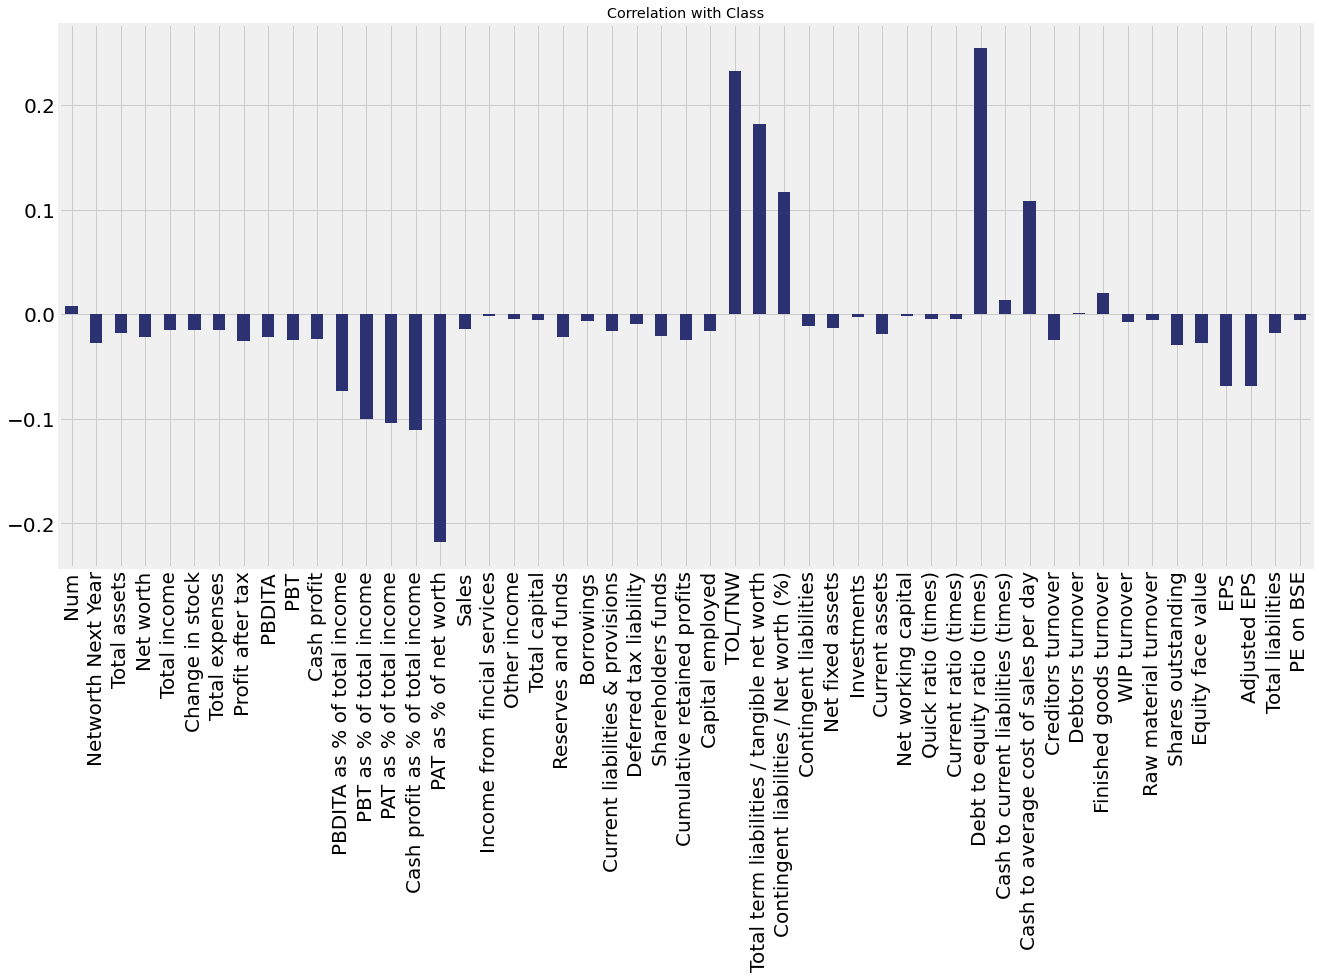

In [10]:
# Finding Correlation with target variable
(df_train.drop('Default', axis = 1)).corrwith(df_train.Default).plot.bar(cmap = 'crest_r',
        figsize = (20, 10), title = "Correlation with Class", fontsize = 20,
        rot = 90, grid = True)

In [11]:
df_train['Default'].value_counts()

0    4022
1     234
Name: Default, dtype: int64

# **Data Distribution and Outlier Detection**

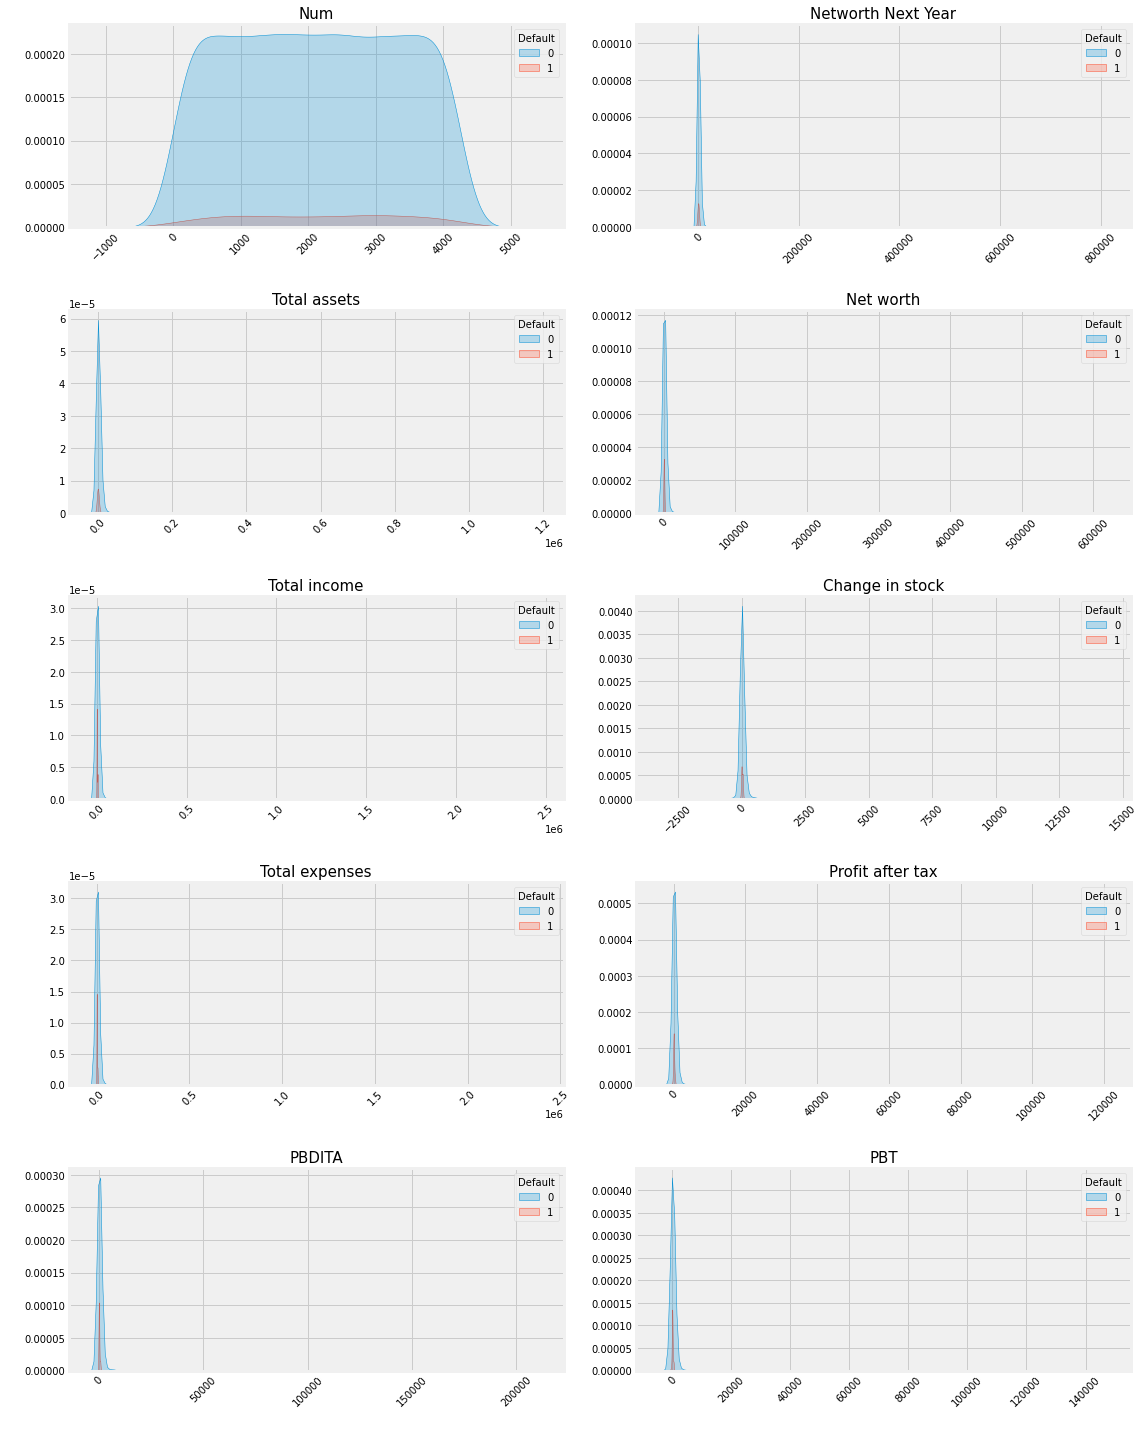

In [13]:
"""Distribution of First 10 Columns"""

plt.figure(figsize = (16,20))
for i,col in enumerate(list(df_train.columns)[:10]):
  plt.subplot(5,2,i+1)
  sns.kdeplot(x = col, data = df_train, hue = 'Default',  shade = True)
  plt.xticks(rotation = 45)
  plt.title(col, fontsize = 15)
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.tight_layout()



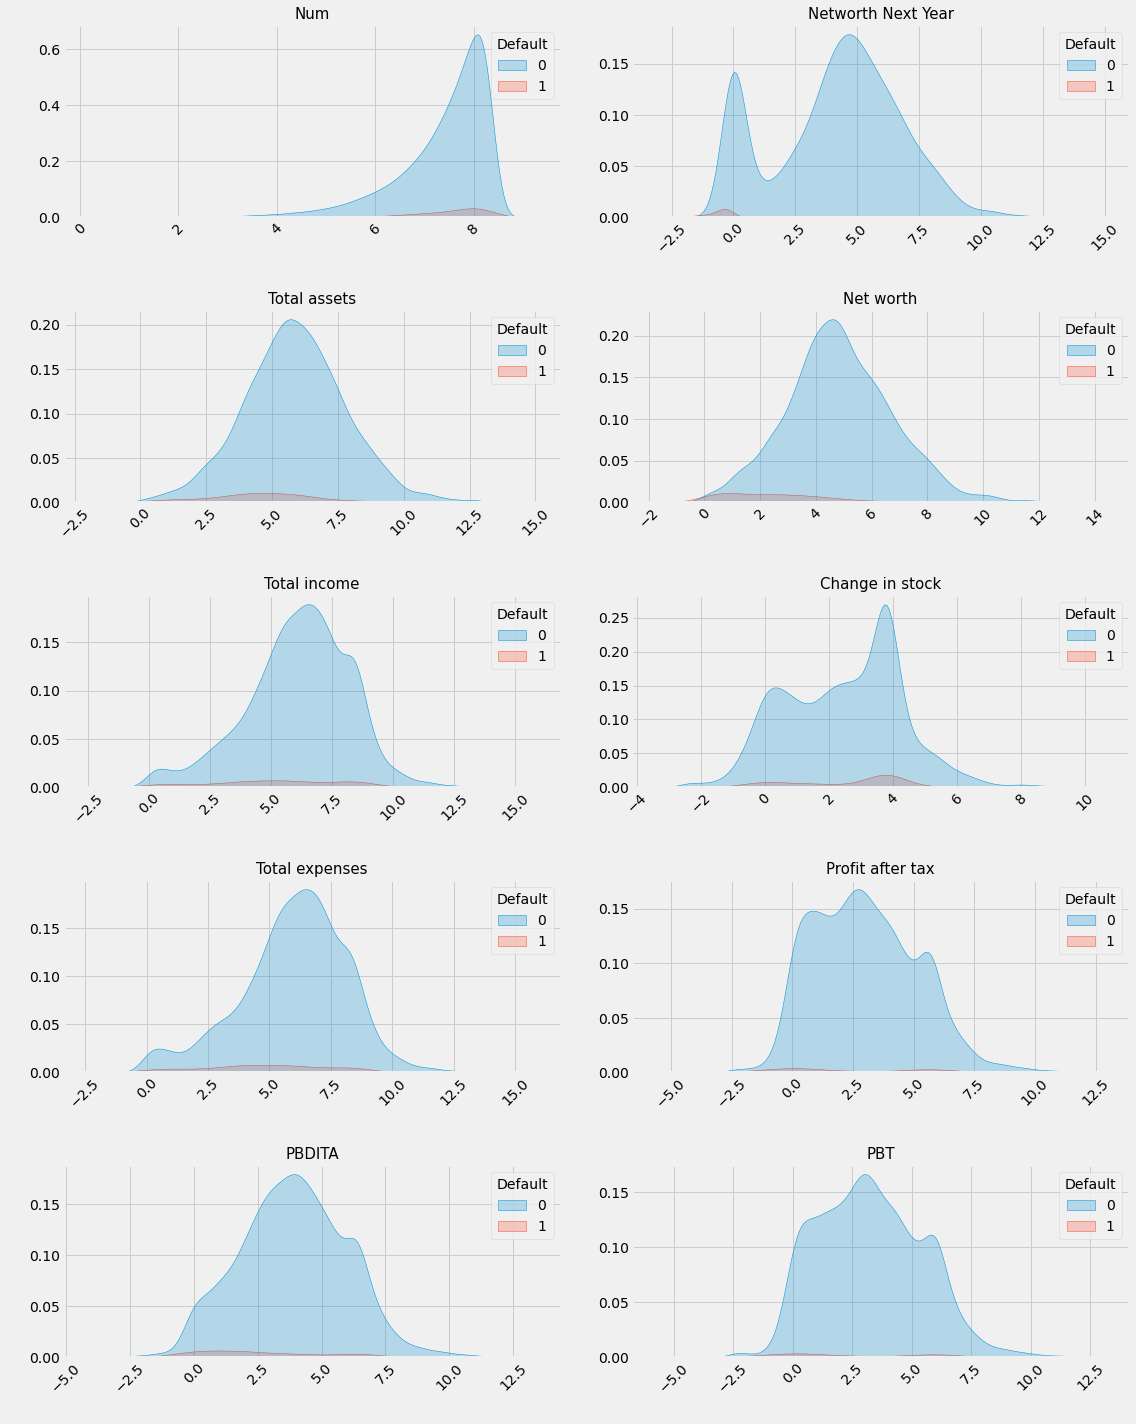

In [26]:
"""Log Distribution of First 10 Columns"""
plt.figure(figsize = (16,20))
for i,col in enumerate(list(df_train.columns)[:10]):
  plt.subplot(5,2,i+1)
  sns.kdeplot(x = np.log1p(df_train[col]), hue = df_train['Default'],  shade = True)
  plt.xticks(rotation = 45)
  plt.title(col, fontsize = 15)
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.tight_layout()

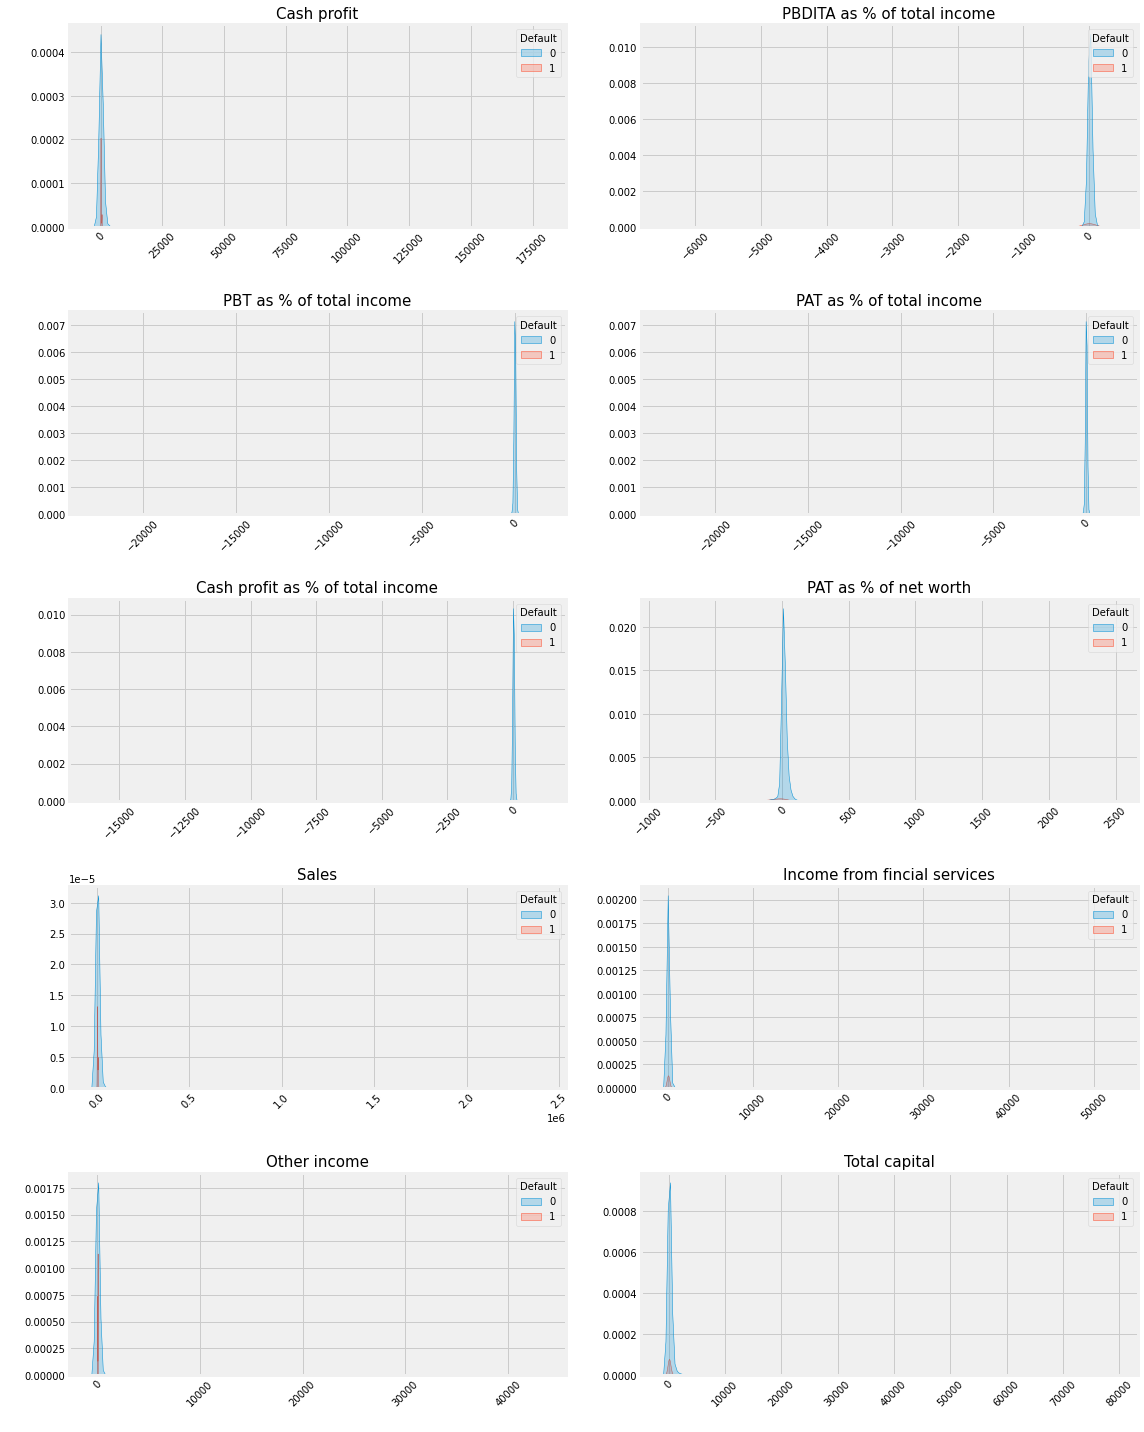

In [14]:
"""Distribution of Columns 10 to 20"""

plt.figure(figsize = (16,20))
for i,col in enumerate(list(df_train.columns)[10:20]):
  plt.subplot(5,2,i+1)
  sns.kdeplot(x = col, data = df_train, hue = 'Default',  shade = True)
  plt.xticks(rotation = 45)
  plt.title(col, fontsize = 15)
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.tight_layout()

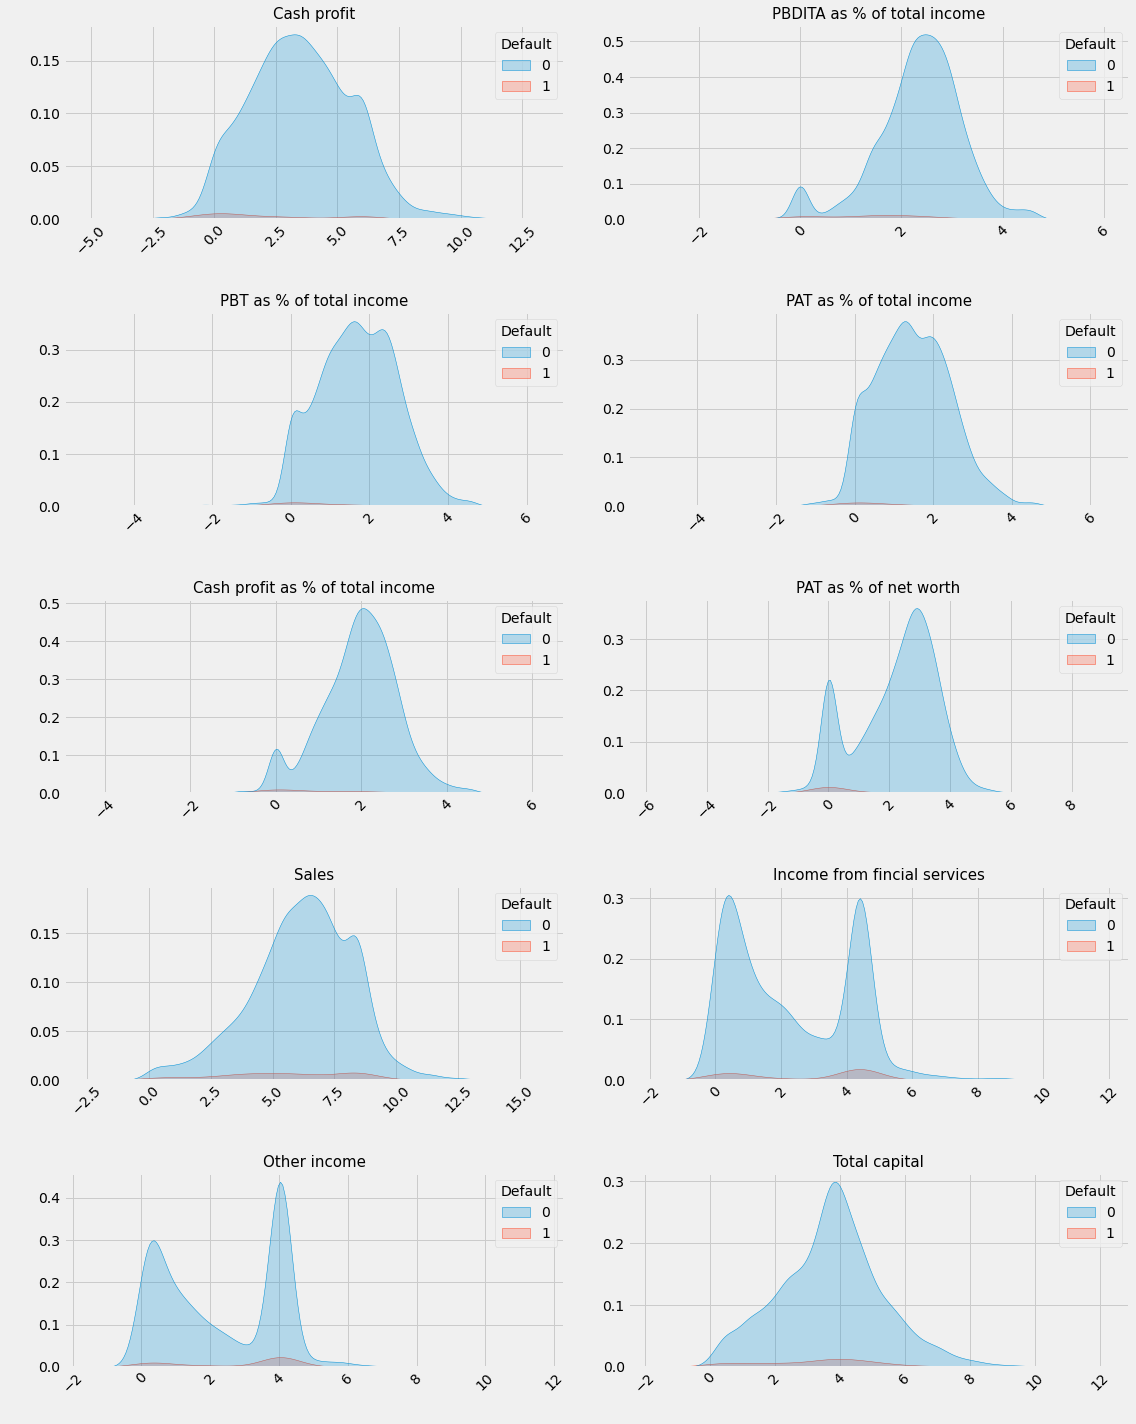

In [27]:
"""Log Distribution of Columns 10 to 20"""

plt.figure(figsize = (16,20))
for i,col in enumerate(list(df_train.columns)[10:20]):
  plt.subplot(5,2,i+1)
  sns.kdeplot(x = np.log1p(df_train[col]), hue = df_train['Default'],  shade = True)
  plt.xticks(rotation = 45)
  plt.title(col, fontsize = 15)
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.tight_layout()

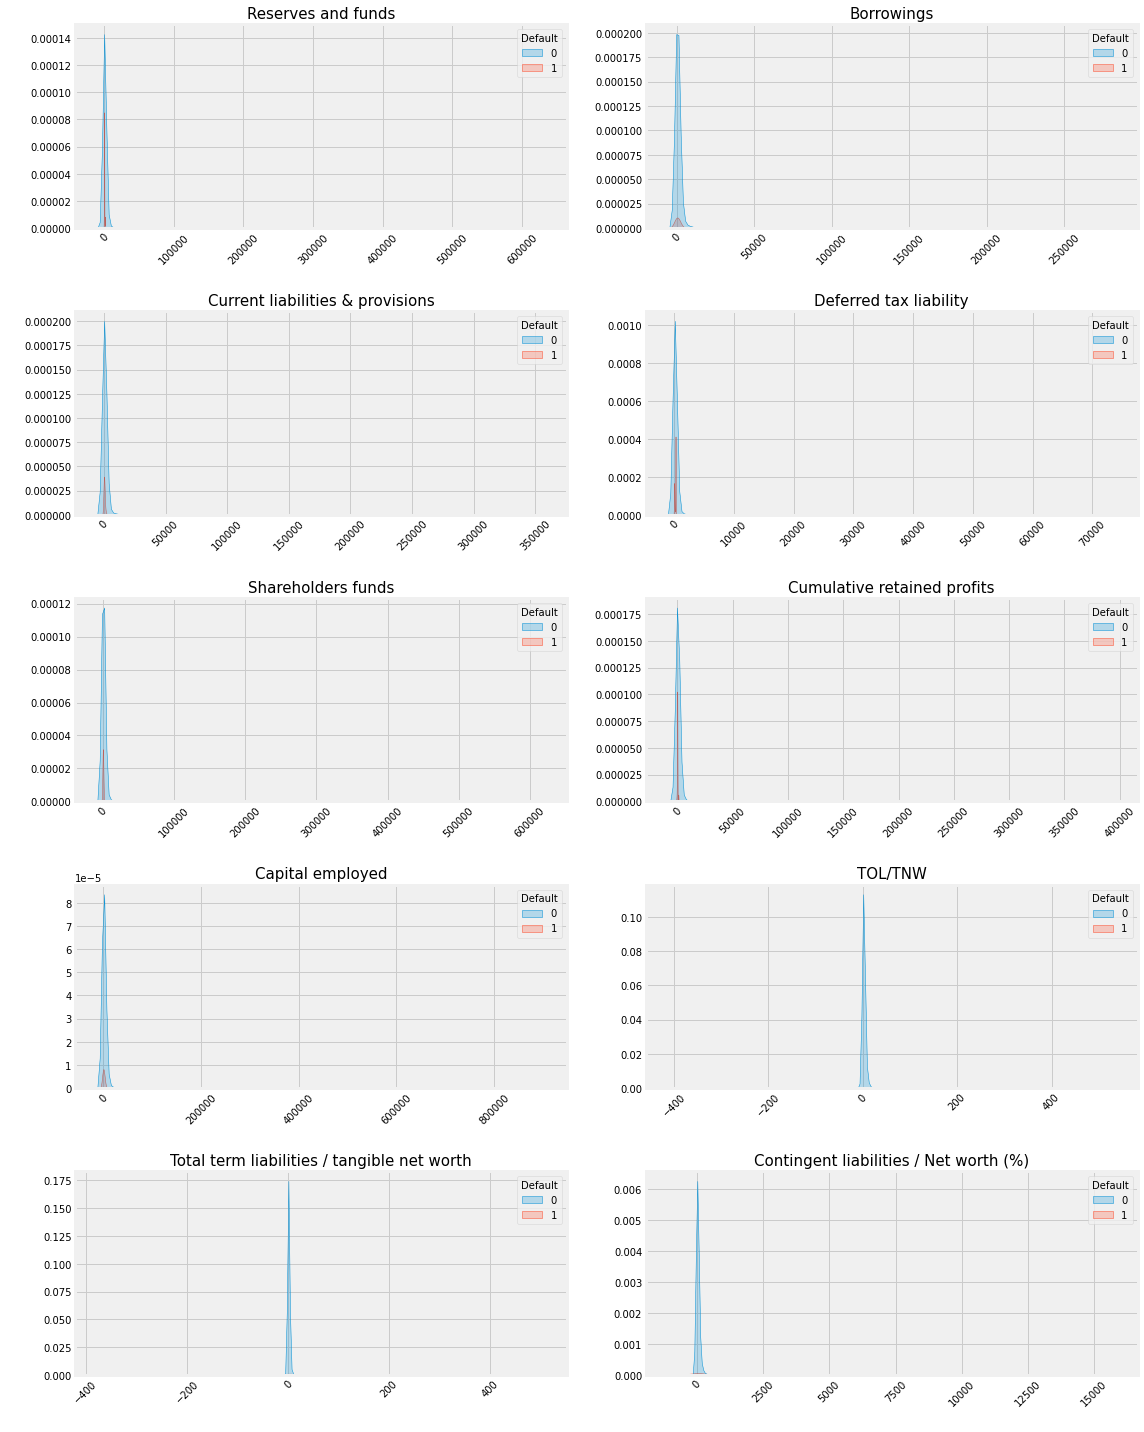

In [15]:
"""Distribution of Columns 20 to 30"""
plt.figure(figsize = (16,20))
for i,col in enumerate(list(df_train.columns)[20:30]):
  plt.subplot(5,2,i+1)
  sns.kdeplot(x = col, data = df_train, hue = 'Default',  shade = True)
  plt.xticks(rotation = 45)
  plt.title(col, fontsize = 15)
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.tight_layout()

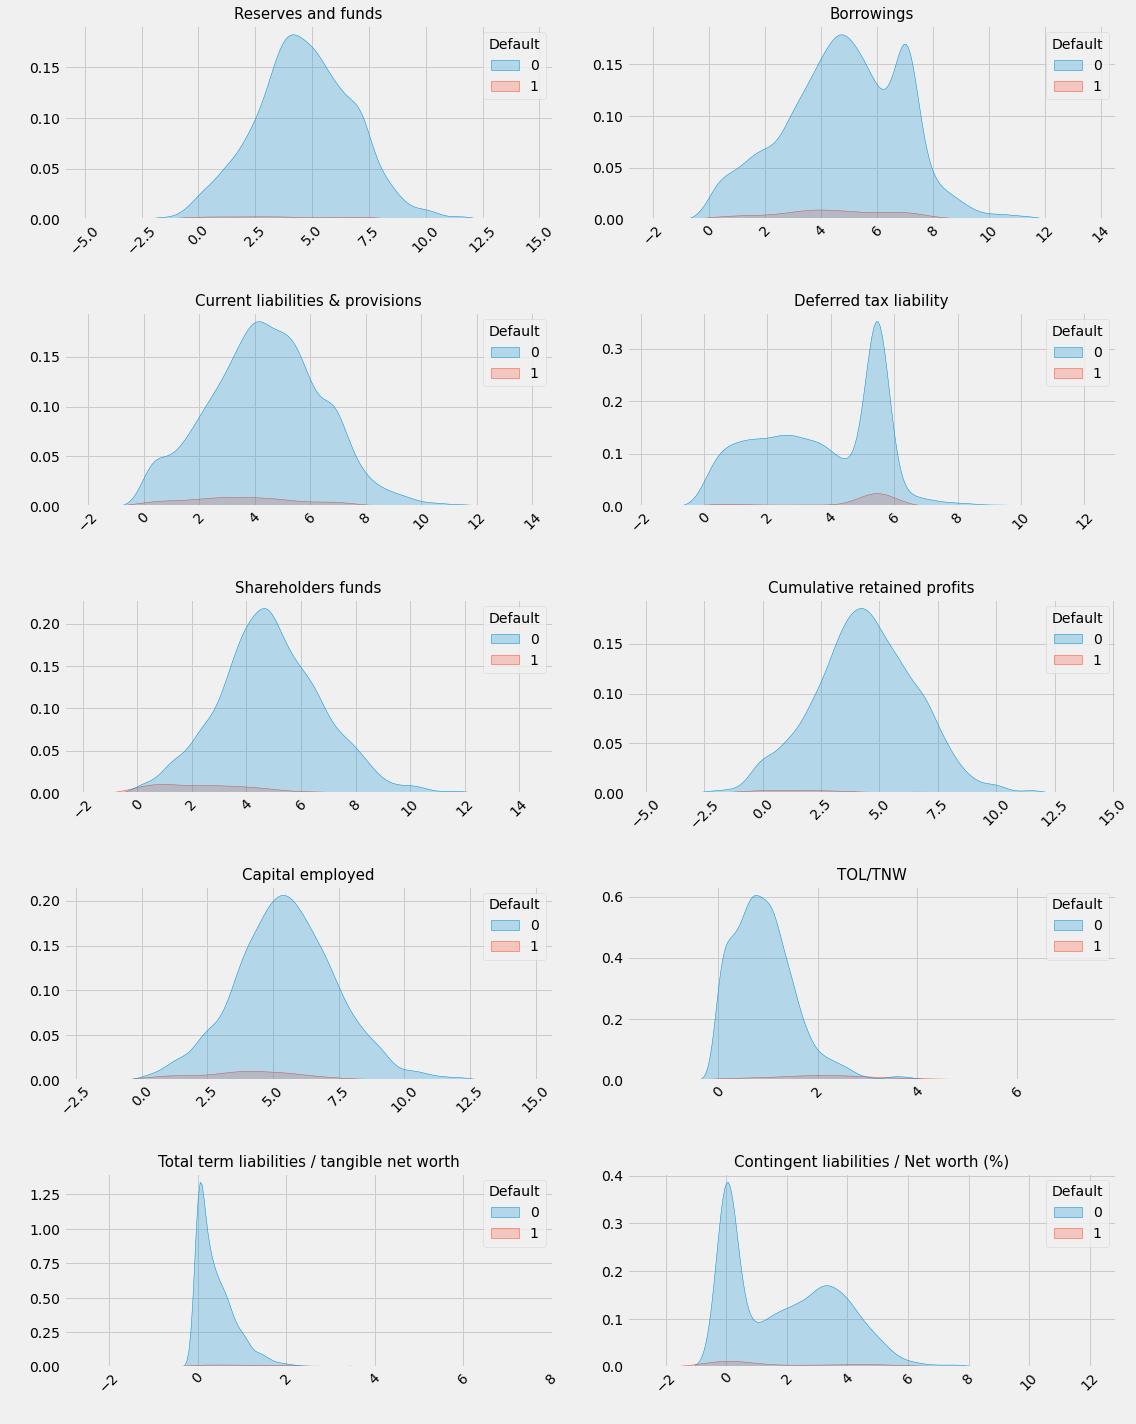

In [29]:
"""Log Distribution of Columns 20 to 30"""
plt.figure(figsize = (16,20))
for i,col in enumerate(list(df_train.columns)[20:30]):
  plt.subplot(5,2,i+1)
  sns.kdeplot(x = np.log1p(df_train[col]),  hue =df_train['Default'],  shade = True)
  plt.xticks(rotation = 45)
  plt.title(col, fontsize = 15)
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.tight_layout()

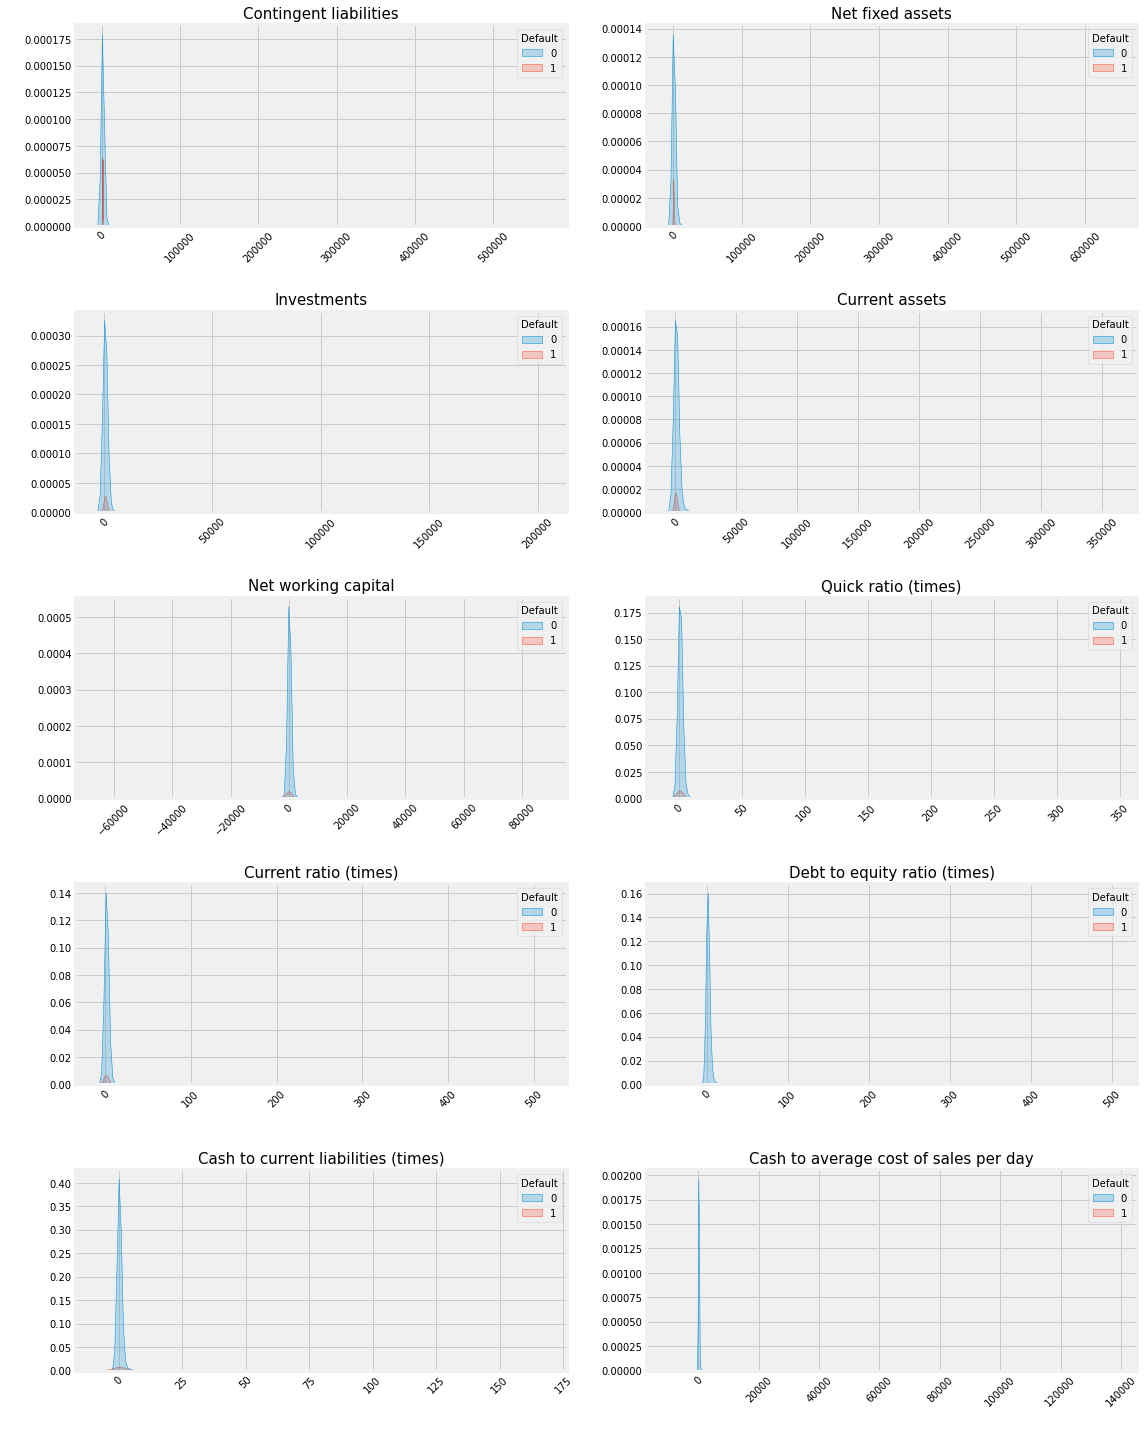

In [16]:
"""Distribution of Columns 30 to 40"""
plt.figure(figsize = (16,20))
for i,col in enumerate(list(df_train.columns)[30:40]):
  plt.subplot(5,2,i+1)
  sns.kdeplot(x = col, data = df_train, hue = 'Default',  shade = True)
  plt.xticks(rotation = 45)
  plt.title(col, fontsize = 15)
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.tight_layout()

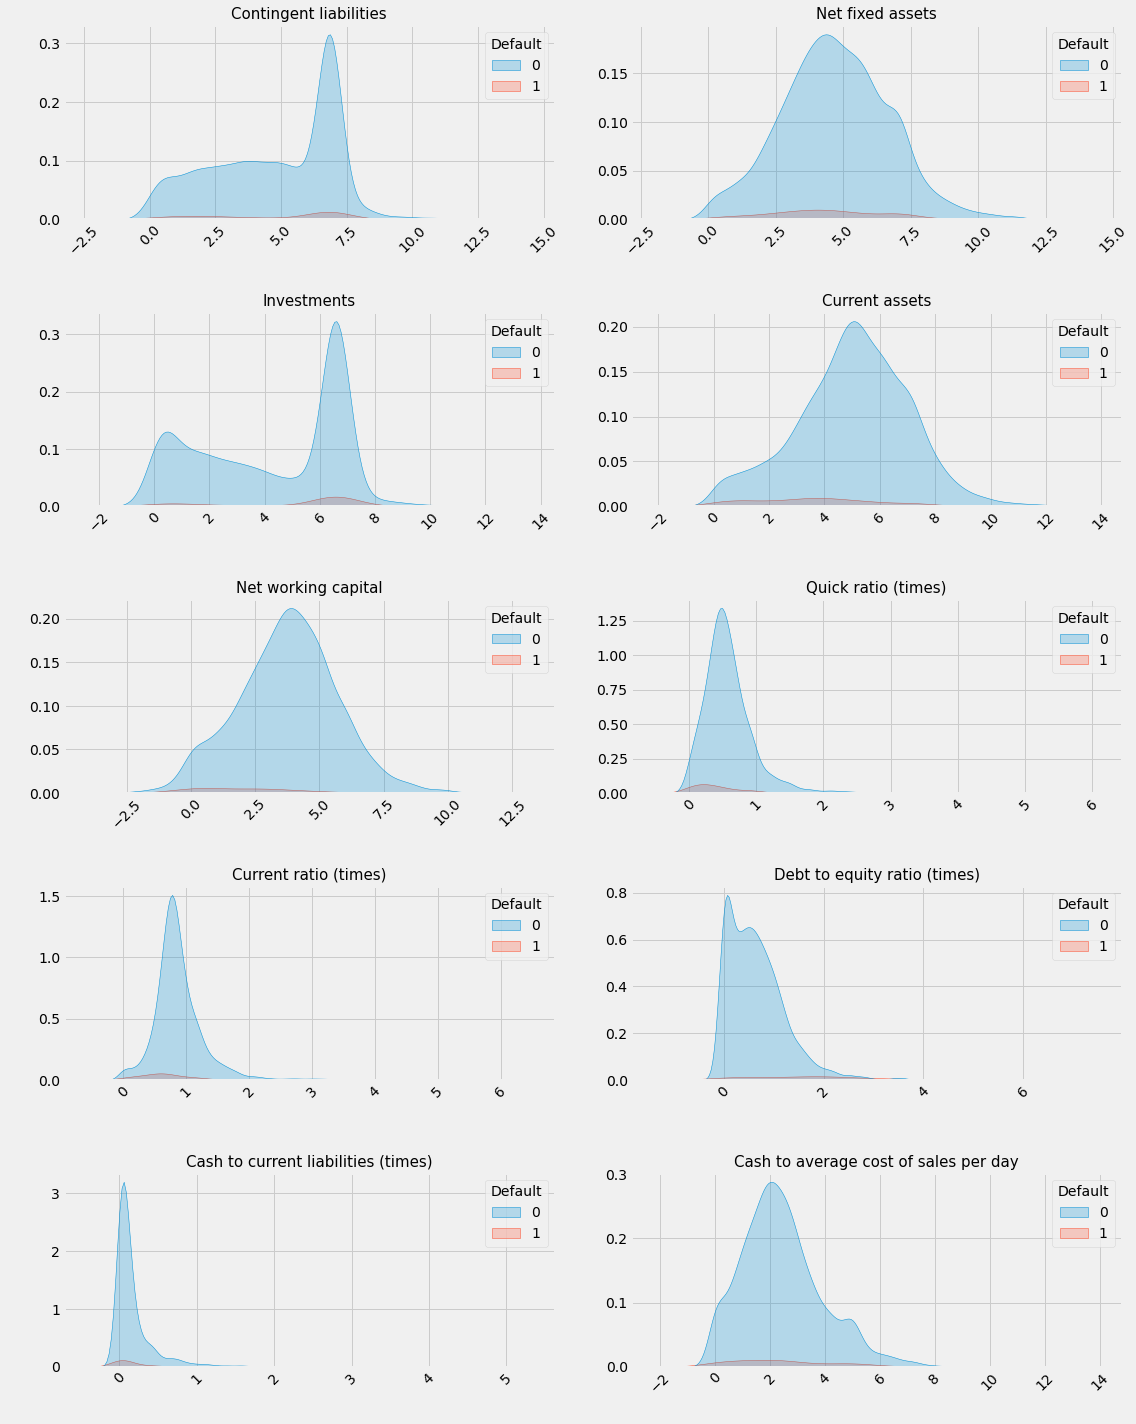

In [30]:
"""Log Distribution of Columns 30 to 40"""
plt.figure(figsize = (16,20))
for i,col in enumerate(list(df_train.columns)[30:40]):
  plt.subplot(5,2,i+1)
  sns.kdeplot(x = np.log1p(df_train[col]), hue = df_train['Default'],  shade = True)
  plt.xticks(rotation = 45)
  plt.title(col, fontsize = 15)
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.tight_layout()

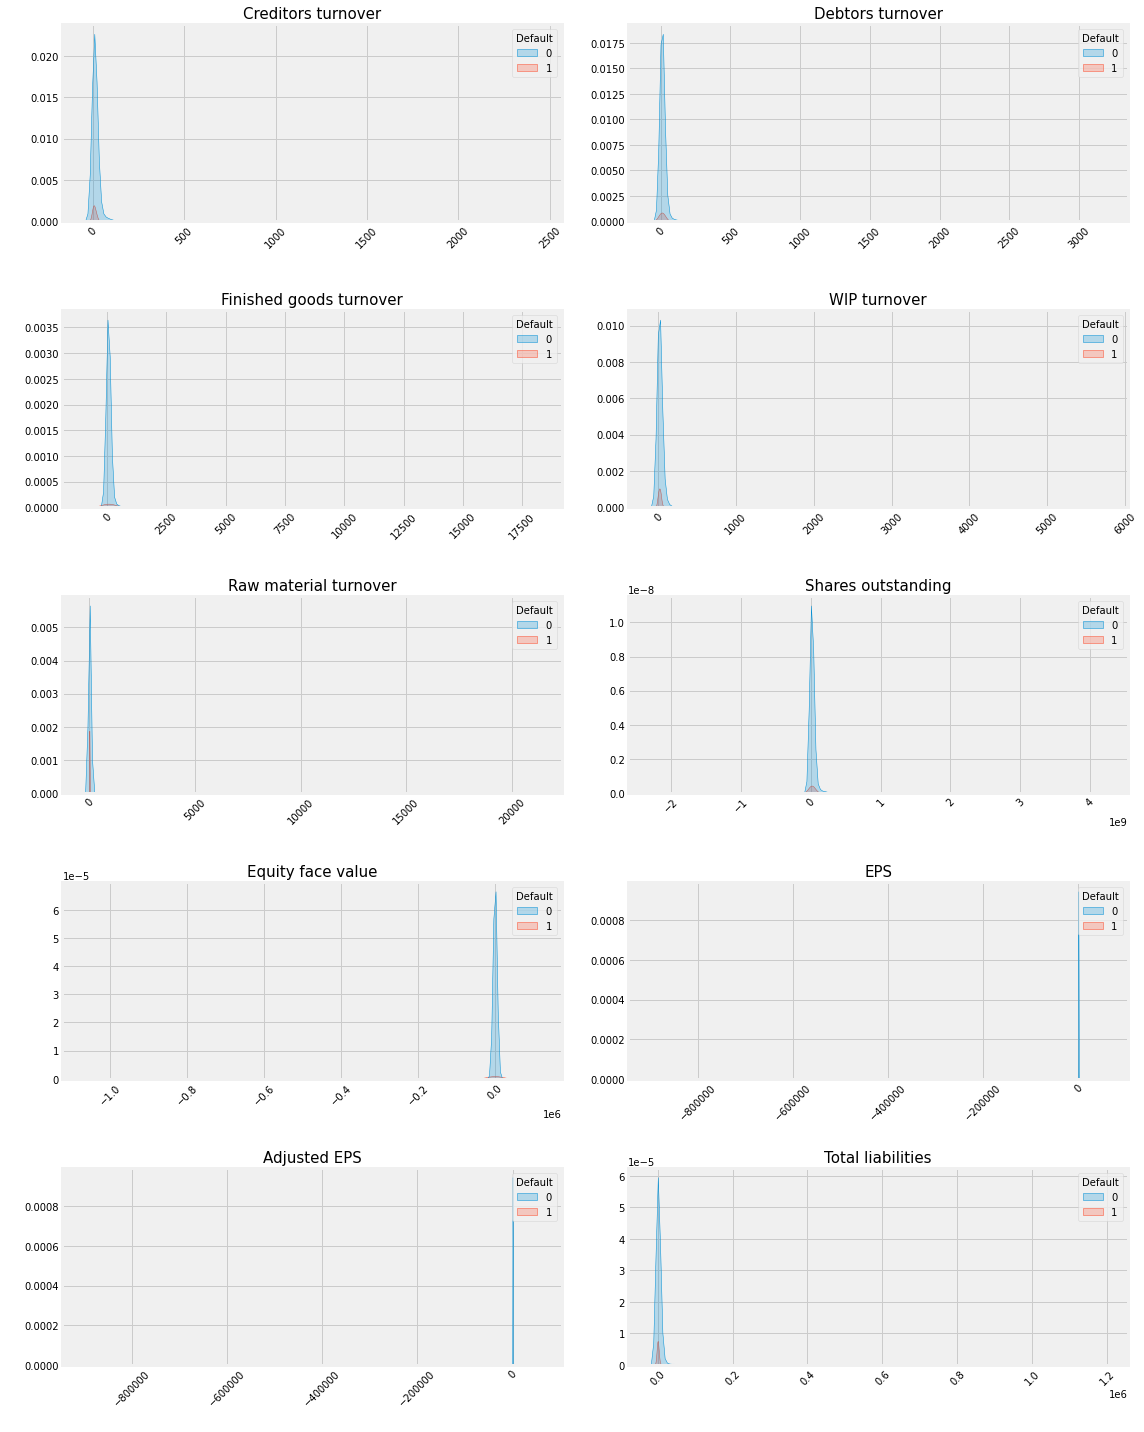

In [17]:
"""Distribution of Columns 40 to 50"""
plt.figure(figsize = (16,20))
for i,col in enumerate(list(df_train.columns)[40:50]):
  plt.subplot(5,2,i+1)
  sns.kdeplot(x = col, data = df_train, hue = 'Default',  shade = True)
  plt.xticks(rotation = 45)
  plt.title(col, fontsize = 15)
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.tight_layout()

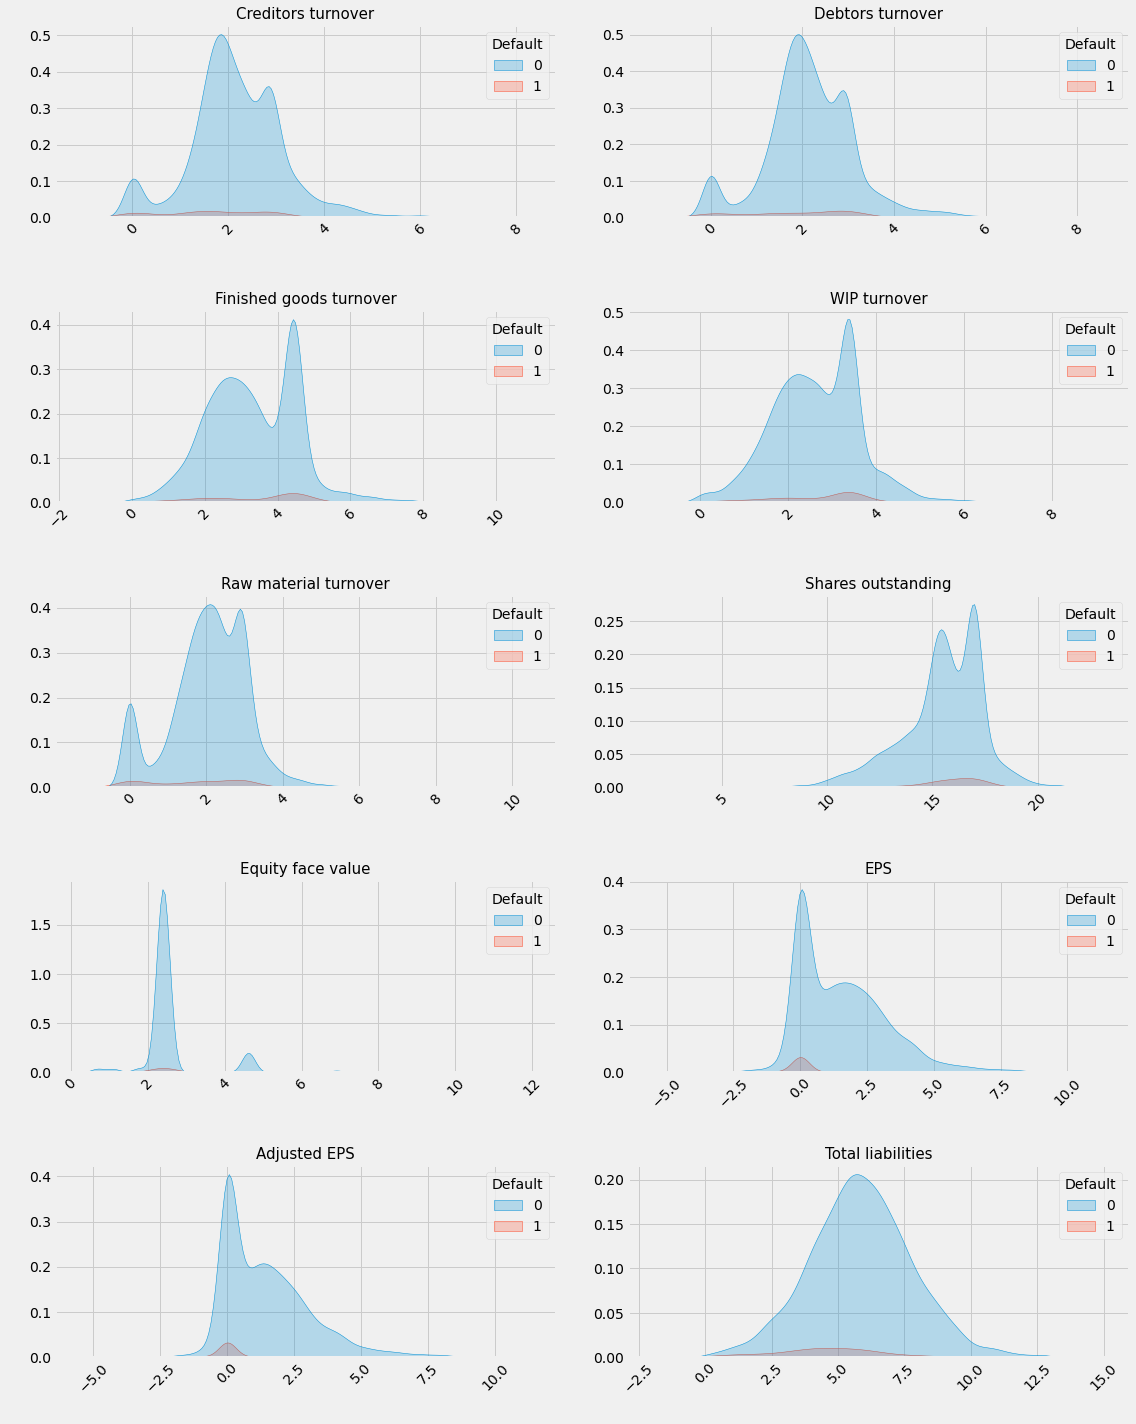

In [31]:
"""Log Distribution of Columns 40 to 50"""
plt.figure(figsize = (16,20))
for i,col in enumerate(list(df_train.columns)[40:50]):
  plt.subplot(5,2,i+1)
  sns.kdeplot(x = np.log1p(df_train[col]), hue = df_train['Default'],  shade = True)
  plt.xticks(rotation = 45)
  plt.title(col, fontsize = 15)
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.tight_layout()

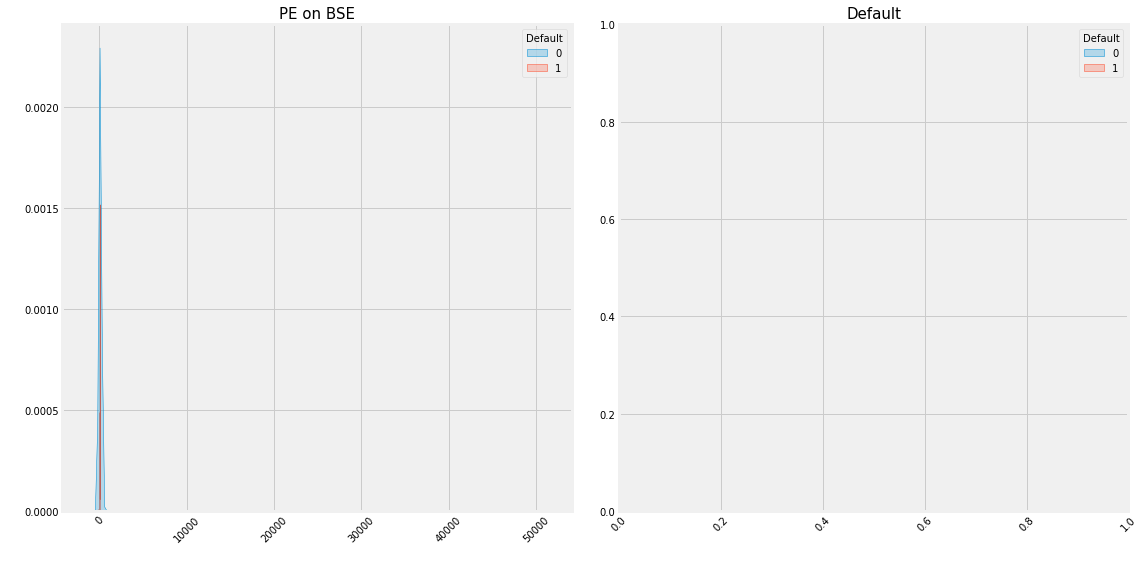

In [18]:
"""Distribution of Columns 50 & 51"""
plt.figure(figsize = (16,8))
for i,col in enumerate(list(df_train.columns)[50:52]):
  plt.subplot(1,2,i+1)
  sns.kdeplot(x = col, data = df_train, hue = 'Default',  shade = True)
  plt.xticks(rotation = 45)
  plt.title(col, fontsize = 15)
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.tight_layout()

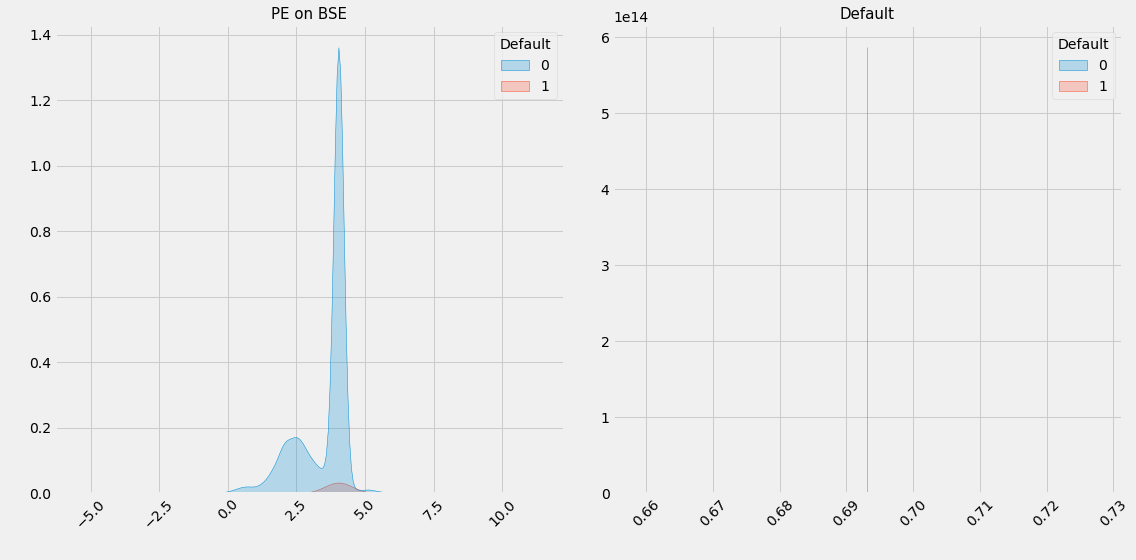

In [32]:
"""Log Distribution of Columns 50 & 51"""
plt.figure(figsize = (16,8))
for i,col in enumerate(list(df_train.columns)[50:52]):
  plt.subplot(1,2,i+1)
  sns.kdeplot(x = np.log1p(df_train[col]),  hue = df_train['Default'],  shade = True)
  plt.xticks(rotation = 45)
  plt.title(col, fontsize = 15)
  plt.xlabel(" ")
  plt.ylabel(" ")
  plt.tight_layout()

## **What does Imbalanced Data do?**
- Let's understand using sample of the new_df2 data and train 3 models on them.
- We will use Isolation Forest Algorithm and Local Outlier Factor (LOF) as these two algorithm will not be impacted by imbalanced data.
- Finally we will use Support Vector Machine (SVM) as that will be affected by imbalanced data.  

In [33]:
#Create independent and Dependent Features
columns = df_train.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ['Num', 'Default']]
# Store the variable we are predicting 
target = "Default"
# Define a random state 
state = np.random.RandomState(42)
X = df_train[columns]
Y = df_train[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(4256, 50)
(4256,)


In [34]:
#Determine the number of fraud and valid transactions in the dataset
Fraud = df_train[df_train['Default']==1]
Valid = df_train[df_train['Default']==0]
outlier_fraction = len(Fraud)/float(len(Valid))

## **Isolation Forest Algorithm :**

---



- One of the newest techniques to detect anomalies is called Isolation Forests. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

- This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

- Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

- How Isolation Forests Work The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

- The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

## **Local Outlier Factor(LOF) Algorithm**

---



- The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

- The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

In [35]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [36]:
%%time
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

Isolation Forest: 398
Accuracy Score :
0.9064849624060151
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4022
           1       0.17      0.18      0.17       234

    accuracy                           0.91      4256
   macro avg       0.56      0.56      0.56      4256
weighted avg       0.91      0.91      0.91      4256

Local Outlier Factor: 430
Accuracy Score :
0.8989661654135338
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.94      0.95      4022
           1       0.10      0.11      0.11       234

    accuracy                           0.90      4256
   macro avg       0.53      0.53      0.53      4256
weighted avg       0.90      0.90      0.90      4256

Support Vector Machine: 1791
Accuracy Score :
0.5791823308270677
Classification Report :
              precision    recall  f1-score   support

           0       0.95      0.59 


### **Observations :**

---



- Isolation Forest detected 73 errors versus Local Outlier Factor detecting 97 errors vs. SVM detecting 20495 errors
- Isolation Forest has a 99.73% more accurate than LOF of 99.61% and SVM of 64.94
- When comparing error precision & recall for 3 models , the Isolation Forest performed much better than the LOF as we can see that the detection of fraud cases is around 27 % versus LOF detection rate of just 2 % and SVM of 0%.
- So overall Isolation Forest Method performed much better in determining the fraud cases which is around 30%.
- We can also improve on this accuracy by increasing the sample size or use deep learning algorithms however at the cost of computational expense.We can also use complex anomaly detection models to get better accuracy in determining more fraudulent cases



# **Taking care of Imbalanced Dataset by using ``SMOTETomek``**

## **Oversampling**

**Oversampling is just the opposite of undersampling. Here the class containing less data is made equivalent to the class containing more data. This is done by adding more data to the least sample containing class.** 

## **Undersampling**

**This technique samples down or reduces the samples of the class containing more data equivalent to the class containing the least samples. Suppose class A has 900 samples and class B has 100 samples, then the imbalance ratio is 9:1. Using the undersampling technique we keep class B as 100 samples and from class A we randomly select 100 samples out of 900. Then the ratio becomes 1:1 and we can say it’s balanced.**

## **SMOTETomek**

**SMOTETomek is somewhere upsampling and downsampling. SMOTETomek is a hybrid method which is a mixture of the above two methods, it uses an under-sampling method (Tomek) with an oversampling method (SMOTE). This is present within imblearn.combine module.**

In [37]:
#Create independent and Dependent Features
columns = df_train.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Num", "Default"]]
# Store the variable we are predicting 
target = "Default"
# Define a random state 
state = np.random.RandomState(42)
X = df_train[columns]
Y = df_train[[target]]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(4256, 50)
(4256, 1)


## **SMOTETomek for handling unbalanced data.**

In [38]:
%%time
from imblearn.combine import SMOTETomek
# Implementing Oversampling for Handling Imbalanced 
smk = SMOTETomek(random_state=42)
col_X = list(X.columns)
col_y = list(Y.columns)
X_res,y_res=smk.fit_resample(X,Y)
X_res = pd.DataFrame(X_res, columns = col_X)
y_res = pd.DataFrame(y_res, columns = col_y)
print(X_res.shape,y_res.shape)

(7344, 50) (7344, 1)
CPU times: user 1.07 s, sys: 511 ms, total: 1.58 s
Wall time: 1.25 s


In [39]:
df = X_res
df['Default'] = y_res['Default'].values
print(f"shape of dataset resampling: {df.shape}")

from collections import Counter
print(f'Original dataset Class variable count {Counter(df_train["Default"])}')
print(f'Resampled dataset Class variable count {Counter(df["Default"])}')

shape of dataset resampling: (7344, 51)
Original dataset Class variable count Counter({0: 4022, 1: 234})
Resampled dataset Class variable count Counter({0: 3672, 1: 3672})


In [40]:
df_train, df_test = train_test_split(df, test_size= 0.2, random_state = 7)


# Preparing data as a tabular matrix
y_train = df_train.Default
X_train = df_train.drop('Default', axis=1)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)



In [46]:
# %%time

useful_features = [c for c in df.columns if c not in ("Default", "Networth Next Year")]

final_test_predictions_log = [] #to store final test predictions
final_valid_predictions_log = [] # to store final validation predictions
scores = [] #to store the scores
xtest, ytest = df_test.copy(), df_test['Default'].copy()


for fold, (train_indicies, valid_indicies) in enumerate(skf.split(X_train,y_train )):   # creating Stratify-5-Folds
    xtrain, ytrain = X_train.iloc[train_indicies], y_train.iloc[train_indicies]         # creating xtrain, ytrain
    xvalid, yvalid = X_train.iloc[valid_indicies], y_train.iloc[valid_indicies]         # creating xvalid and yvalid
    
    
    xtrain = xtrain[useful_features]                                                    # Removing Class variable
    xvalid = xvalid[useful_features]                                                    # Removing Class variable
    xtest = xtest[useful_features]                                                      # Removing Class variable

    # Model building using parameters obtain from Optuna hyper-parameter tuning
    params = {'n_estimators': 8, 'max_depth': 3}
    model_log = LogisticRegression(random_state= 42, C=0.5)   # instantiate RandomForestClassifier Class
    model_log.fit(xtrain, ytrain)                                                        # Training the model on training set

    preds_valid = model_log.predict_proba(xvalid)[:, 1]                                  # Predicting Validation set 
    test_preds = model_log.predict_proba(xtest)[:, 1]                                    # Predicting Test Set
    final_test_predictions_log.append(test_preds)                                        # Appending test predictions to list
    final_valid_predictions_log.append(preds_valid)                                      # Appending valid predictions to list
    roc_auc_score_valid = metrics.roc_auc_score(yvalid, preds_valid)                    # Evaluating valid predictions using roc_auc_curve      
    roc_auc_score_test = metrics.roc_auc_score(ytest, test_preds)                       # Evaluating test predictions using roc_auc_curve
    print(f'Fold {fold} AUC_valid: ', roc_auc_score_valid)                              # printing fold and respective roc_auc for validation set 
    print(f'Fold {fold} AUC_test: ', roc_auc_score_test)                                # printing fold and respective roc_auc for test set
    scores.append(roc_auc_score_valid)                                                  # Appending roc_auc_score to list.
    
print(np.mean(scores), np.std(scores))                                                  # printing mean and standard deviation of scores 

Fold 0 AUC_valid:  0.8345371577574967
Fold 0 AUC_test:  0.8316233453224072
Fold 1 AUC_valid:  0.7207373605678691
Fold 1 AUC_test:  0.7099818309911379
Fold 2 AUC_valid:  0.5415094886281326
Fold 2 AUC_test:  0.5548778226853053
Fold 3 AUC_valid:  0.8174003488297976
Fold 3 AUC_test:  0.8170343727983981
Fold 4 AUC_valid:  0.8216259988295079
Fold 4 AUC_test:  0.8240442730542474
0.7471620709225608 0.11054768017811477


In [45]:
# %%time
useful_features = [c for c in df.columns if c not in ("Default", "Networth Next Year")]

final_test_predictions_rf = [] #to store final test predictions
final_valid_predictions_rf = [] # to store final validation predictions
scores = [] #to store the scores
xtest, ytest = df_test.copy(), df_test['Default'].copy()


for fold, (train_indicies, valid_indicies) in enumerate(skf.split(X_train,y_train )):   # creating Stratify-5-Folds
    xtrain, ytrain = X_train.iloc[train_indicies], y_train.iloc[train_indicies]         # creating xtrain, ytrain
    xvalid, yvalid = X_train.iloc[valid_indicies], y_train.iloc[valid_indicies]         # creating xvalid and yvalid
    
    
    xtrain = xtrain[useful_features]                                                    # Removing Class variable
    xvalid = xvalid[useful_features]                                                    # Removing Class variable
    xtest = xtest[useful_features]                                                      # Removing Class variable


    model_rf = RandomForestClassifier(criterion = 'entropy',random_state= 7)   # instantiate RandomForestClassifier Class
    model_rf.fit(xtrain, ytrain)                                                        # Training the model on training set

    preds_valid = model_rf.predict_proba(xvalid)[:, 1]                                  # Predicting Validation set 
    test_preds = model_rf.predict_proba(xtest)[:, 1]                                    # Predicting Test Set
    final_test_predictions_rf.append(test_preds)                                        # Appending test predictions to list
    final_valid_predictions_rf.append(preds_valid)                                      # Appending valid predictions to list
    roc_auc_score_valid = metrics.roc_auc_score(yvalid, preds_valid)                    # Evaluating valid predictions using roc_auc_curve      
    roc_auc_score_test = metrics.roc_auc_score(ytest, test_preds)                       # Evaluating test predictions using roc_auc_curve
    print(f'Fold {fold} AUC_valid: ', roc_auc_score_valid)                              # printing fold and respective roc_auc for validation set 
    print(f'Fold {fold} AUC_test: ', roc_auc_score_test)                                # printing fold and respective roc_auc for test set
    scores.append(roc_auc_score_valid)                                                  # Appending roc_auc_score to list.
    
print(np.mean(scores), np.std(scores))                                                  # printing mean and standard deviation of scores 

Fold 0 AUC_valid:  0.9972620599739244
Fold 0 AUC_test:  0.9968788238347732
Fold 1 AUC_valid:  0.9948486165435318
Fold 1 AUC_test:  0.9966211205458119
Fold 2 AUC_valid:  0.9939229320585252
Fold 2 AUC_test:  0.9960779042604472
Fold 3 AUC_valid:  0.9973924682895171
Fold 3 AUC_test:  0.9968686269420446
Fold 4 AUC_valid:  0.9967145100447916
Fold 4 AUC_test:  0.9968704809225407
0.996028117382058 0.0013912749606503105


In [47]:
# %%time
useful_features = [c for c in df.columns if c not in ("Default", "Networth Next Year")]

final_test_predictions_xgb = [] #to store final test predictions
final_valid_predictions_xgb = [] # to store final validation predictions
scores = [] #to store the scores
xtest, ytest = df_test.copy(), df_test['Default'].copy()


for fold, (train_indicies, valid_indicies) in enumerate(skf.split(X_train,y_train )):   # creating Stratify-5-Folds
    xtrain, ytrain = X_train.iloc[train_indicies], y_train.iloc[train_indicies]         # creating xtrain, ytrain
    xvalid, yvalid = X_train.iloc[valid_indicies], y_train.iloc[valid_indicies]         # creating xvalid and yvalid
    
    
    xtrain = xtrain[useful_features]                                                    # Removing Class variable
    xvalid = xvalid[useful_features]                                                    # Removing Class variable
    xtest = xtest[useful_features]                                                      # Removing Class variable

    # Model building using parameters obtain from Optuna hyper-parameter tuning
    params = {'n_estimators': 8, 'max_depth': 3}
    model_xgb = XGBClassifier(random_state= 7)   # instantiate RandomForestClassifier Class
    model_xgb.fit(xtrain, ytrain)                                                        # Training the model on training set

    preds_valid = model_xgb.predict_proba(xvalid)[:, 1]                                  # Predicting Validation set 
    test_preds = model_xgb.predict_proba(xtest)[:, 1]                                    # Predicting Test Set
    final_test_predictions_xgb.append(test_preds)                                        # Appending test predictions to list
    final_valid_predictions_xgb.append(preds_valid)                                      # Appending valid predictions to list
    roc_auc_score_valid = metrics.roc_auc_score(yvalid, preds_valid)                    # Evaluating valid predictions using roc_auc_curve      
    roc_auc_score_test = metrics.roc_auc_score(ytest, test_preds)                       # Evaluating test predictions using roc_auc_curve
    print(f'Fold {fold} AUC_valid: ', roc_auc_score_valid)                              # printing fold and respective roc_auc for validation set 
    print(f'Fold {fold} AUC_test: ', roc_auc_score_test)                                # printing fold and respective roc_auc for test set
    scores.append(roc_auc_score_valid)                                                  # Appending roc_auc_score to list.
    
print(np.mean(scores), np.std(scores))                                                  # printing mean and standard deviation of scores 

Fold 0 AUC_valid:  0.9947834274952919
Fold 0 AUC_test:  0.9946827839371131
Fold 1 AUC_valid:  0.9937012892945097
Fold 1 AUC_test:  0.9944046868626942
Fold 2 AUC_valid:  0.9894393741851368
Fold 2 AUC_test:  0.9937706255330193
Fold 3 AUC_valid:  0.9945386696952665
Fold 3 AUC_test:  0.9944287886091439
Fold 4 AUC_valid:  0.9953049942924028
Fold 4 AUC_test:  0.9949275093626014
0.9935535509925216 0.002121267833705127


In [48]:

%%time
useful_features = [c for c in df.columns if c not in ("Default", "Networth Next Year")]

final_test_predictions_vclf = [] #to store final test predictions
final_valid_predictions_vclf = [] # to store final validation predictions
scores = [] #to store the scores

for fold, (train_indicies, valid_indicies) in enumerate(skf.split(X_train,y_train )): # Creating Strtify-5-Folds
    xtrain, ytrain = X_train.iloc[train_indicies], y_train.iloc[train_indicies]       # Creating xtrain and ytrain
    xvalid, yvalid = X_train.iloc[valid_indicies], y_train.iloc[valid_indicies]       # Creating xvalid and yvalid
    xtest, ytest = df_test.copy(), df_test['Default'].copy()                            # Creating xtest and ytest
    
    # Removing Class varaibles from xtrain, xvalid and xtest
    xtrain = xtrain[useful_features].values
    xvalid = xvalid[useful_features].values
    xtest = xtest[useful_features].values
    
    model_vclf = VotingClassifier(estimators=[('LogisticRegression', model_log),  
                                              ('XGBoostClassifier', model_xgb),      # Passing second model - XGBoost
                                              ('RandomForestClassifier', model_rf)], # Passing third model - RandomForestClassifier
                                  voting='soft')                                      # Used Soft voting
    model_vclf.fit(xtrain, ytrain)                                                    # Training the model

    preds_valid = model_vclf.predict_proba(xvalid)[:, 1]                              # Prediction on validation data
    test_preds = model_vclf.predict_proba(xtest)[:, 1]                                # Prediction on test data
    final_test_predictions_vclf.append(test_preds)                                    # Appending test predictions to list
    final_valid_predictions_vclf.append(preds_valid)                                  # Appending validation predictions to list
    roc_auc_score_valid = metrics.roc_auc_score(yvalid, preds_valid)                  # Evaluating validation predictions using roc_auc_score
    roc_auc_score_test = metrics.roc_auc_score(ytest, test_preds)                     # Evaluating Test predictions using roc_auc_score
    print(f'Fold {fold} AUC_valid: ', roc_auc_score_valid)                            # Printing fold and AUC_validation
    print(f'Fold {fold} AUC_test: ', roc_auc_score_test)                              # Printing fold and AUC_test
    scores.append(roc_auc_score_valid)                                                # Appending validation score to list
    
    
print(np.mean(scores), np.std(scores))  

Fold 0 AUC_valid:  0.9960437490945966
Fold 0 AUC_test:  0.995513367199377
Fold 1 AUC_valid:  0.9946139359698681
Fold 1 AUC_test:  0.9961251807630984
Fold 2 AUC_valid:  0.9926119078661452
Fold 2 AUC_test:  0.995748822722385
Fold 3 AUC_valid:  0.9953614908127966
Fold 3 AUC_test:  0.9949812747969892
Fold 4 AUC_valid:  0.9953571449266125
Fold 4 AUC_test:  0.9941358596907561
0.9947976457340039 0.0011827876824789182
CPU times: user 22.9 s, sys: 1.5 s, total: 24.4 s
Wall time: 22.7 s
